# SLT-CE-7: Mean Field Approximation

**Solve the main part of the exercise to get 1 point. Solve the extension as well to get 2 points.**

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture06.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise10.pdf)

[3] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[4] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[5] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

We will be using the Ising model from the coding exercise 2 for image denoising, also described in Series 10 [2]. Recall that the model orignates from section 8.3.3 of [4]. However, to approximate the inference, instead of using MCMC, we will apply mean field approximation and then compare it to the MCMC estimates.

## Setup

We start by importing necessary python packages.

In [23]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import convolve
import time
import copy

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [2]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [3]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

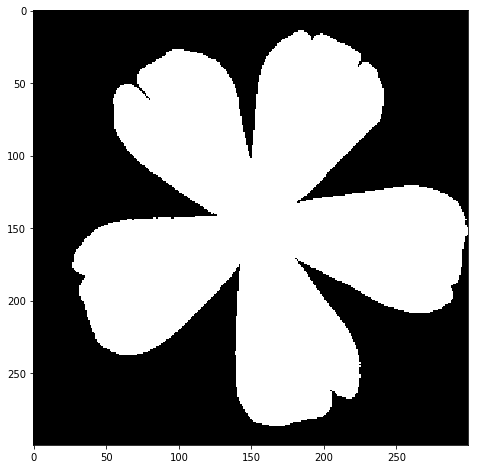

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [89]:
# Fix random seed for reproducibility
np.random.seed(13)
def add_noise_to_image(IMG_ORIGINAL):
    IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
    num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

    perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
    for k in perm:
        i = int(k/IMG_WIDTH)
        j = k%IMG_HEIGHT
        IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]
    return IMG_NOISY_OBSERVATION

IMG_NOISY_OBSERVATION = add_noise_to_image(IMG_ORIGINAL)

Plot the noisy version of the original image

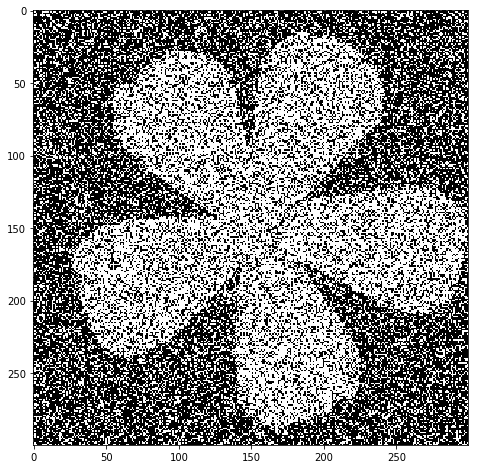

In [90]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as given in [2].

In [7]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [8]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

Estimating loss via mean squared error

In [9]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [10]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [11]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300856.0


## Problem 0

### Mean field approximation

Mean field approximation is a method that can be used to approximate a function which would otherwise be intractable to compute.

In many cost functions we want to compute the normalizing partition function which contains exponentially many terms and is not analytically solvable and we thus resort to approximating it. 

In the Ising model, this problem arises when we want to compute the energy function, which includes a term for the contributions of an elements nearest neighbors. 

The approximation generally works as follows:
1. We want to minimize the KL-Divergence $D(Q||P)$ between the approximation function $Q$ and the target function $P$. $Q$ is chosen to be factorizable. 
2. By deriving the extremality conditions, it can be shown that the optimal approximation is given by:
$$q_{u}(\alpha) = \frac{e^{-\beta h_{u\alpha}}}{\sum_{\nu}e^{-\beta h_{u\nu}}}$$
which is the assignment probability of object $u$ to cluster $\alpha$ and where the term $h_{u\alpha}$ is called the mean field, reflecting the expected cost under the constraint that object $u$ is assigned to cluster $\alpha$.
The mean field $h_{u\alpha}$ is given by: 
$$h_{u\alpha} = E_{Q_ {u \rightarrow \alpha}}\{R(c)\} = \sum_{c \in C}\prod_{i \neq u \leq n} q_i(c(i))\mathbb{I}_{\{c(u) = \alpha\}}R(c)$$

Which can be found by following an iterative, asynchronous updating scheme in an Expectation Maximization fashion.

## Problem 1

With the help of [2], explain the algorithm for solving image denoising using mean field approximation:

### Mean field approximation for Image Denoising
In the image denoising setting, we are looking for an image $\sigma$ to minimize:
    $$E(\sigma) = -\lambda \sum_{i=1}^N h_i\sigma - \sum_{i,j = 1}^N J_{i,j} \sigma_i \sigma_j$$
where $h_i$ is the value of pixel $i$ in the noisy observation.
    
 We thus seek to minimize $KL(p_0 || p) + F(\beta)$, which is equivalent to minimizing the Gibbs free energy $G(p)$, where $F(\beta)$ is the free energy, $p_0$ the proposal distribution and $p$ the true distribution.
 
 It can be shown that:
 $$G(p) = -\lambda \sum_{i=1}^N m_i h_i - \sum_{i=1}^{N-1} \sum_{j=i+1}^N m_i J_{ij} m_j + 1/\beta \sum_{i=1}^N (\frac{1 + m_i}{2}log \frac{1 + m_i}{2} + \frac{1 - m_i}{2}log\frac{1 - m_i}{2})$$

where $m_i$ is the mean field for pixel $i$.
Deriving the stationary equations, we find that $G(p)$ is minimized by:
 
 $$m_k = tanh(\beta(\sum_{i\neq k} J_{ki} m_i + \lambda h_k)), k \in {1,N}$$
 
 Which we can solve by iteratively updating the $m_k$.

## Problem 2

Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the epochs parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.

Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Clearly explain the differences. Does it converge faster? What are the disadvantages and advantages?

Consider running the comparison on another image to prove your point.

Also, feel free to replace our implementation of MCMC with your own.

In [116]:
def metropolis(img_noisy_observation, img_original, epochs):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    T = 1.0

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

In [120]:
def meanfield(img_noisy_observation, img_original, epochs, lambda_= 2.0, beta=1.0, filter_width=3, neighbor_weight=0.1):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)

    # artifically construct energies and losses arrays
    m = copy.copy(img_noisy_observation)
    for i in range(600000):
        j, k = np.random.randint(m.shape[0], size=2)
        filter_matrix = np.zeros(m.shape)
        filter_matrix[j- filter_width:j+filter_width + 1,k- filter_width:k+filter_width + 1] = 1 / neighbor_weight
        filter_matrix[j, k] = 0
        neighbor_sum = np.sum(np.multiply(filter_matrix, m))
        m[j,k] = np.tanh(beta * (neighbor_sum + lambda_ * img_noisy_observation[j, k]))
        if i % 200 == 0:
            energies.append(energy(m,img_noisy_observation))
            losses.append(mse_loss(m,img_original))

    return m, np.asarray(energies), np.asarray(losses)

In [74]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, args=None):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs, *args)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

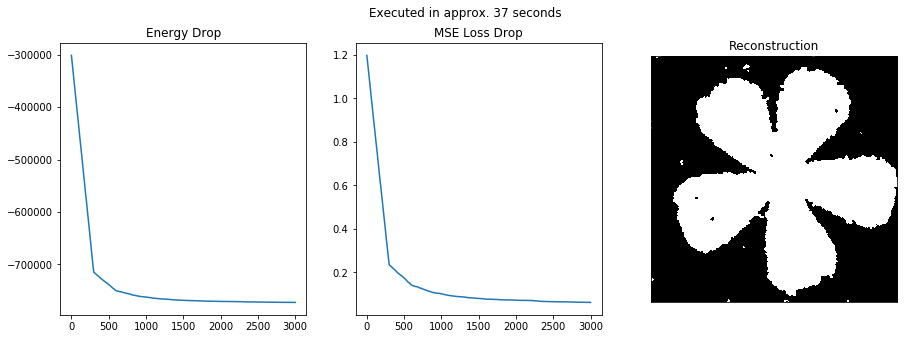

In [117]:
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10, [])

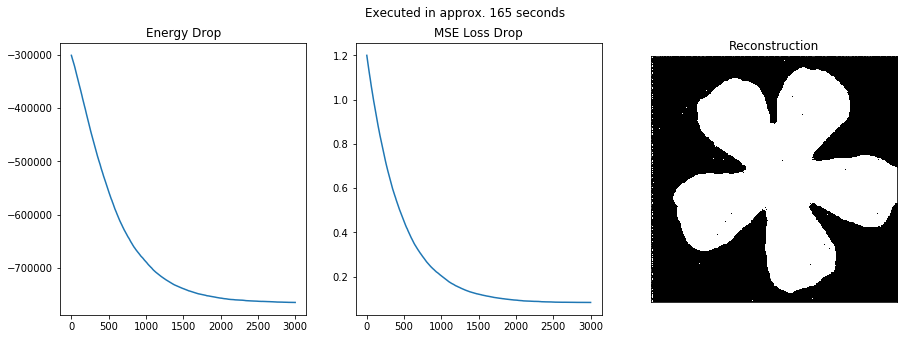

In [121]:
# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5, [2.0,1.0,3,0.1])

Compare and analyze performance: 
### Answer:
The metropolis and mean field algorithms achieve very similar losses. The meanfield approximation seems to lead to smoother edged in the reconstructed image. The metropolis algorithm displays a steeper initial drop in energy  as compared to the more gradual decline for the mean field approximation. Errors in the reconstruction differ betwen the two algorithms: The metropolis algorithm yields larger, homogenous patches of wrong pixels, whereas the mean field approximation leads to more, individual pixels being reconstructed incorrectly. 
My implementation of the mean field approximation has significantly longer runtime. 

Any implementation/computational/numerical issues?
### Answer:
Increasing the number of neighbors that would be considered for a given pixel and giving them a lot of weight s.t. $\sum_{i \neq k} J_{ki} mi >> \lambda$ was crucial for getting good results. 

## Problem 3

Comment on the convergence of the method. How can we tell if the mean field convereged? Do we always reach the global optimum?

### Answer:
* The convergence can be determined by looking at the deriative of the energy as a function of the time with regards to the time: $E(t)/dt$. The approximation has converged iff $E(t)/dt < \epsilon$ for some sufficiently small $\epsilon$. Another way of determining convergence would be to compare reconstructions after a fixed amount of steps and to assume that the algorithm has converged if the difference between the reconstruction is smaller than some $\epsilon$.
* We are not guaranteed to find the global optimum of the loss function. The algorithm might minimize the energy in a way that does not lead to a minimizaiton of the loss. See the last plot in Section 5 as an example of this. 
* We are also not guaranteed to find the global optimum of the energy function. The order in which we visit the pixels and the initialization (noisy image) are random, we might thus get stuck in different local minima. 

## Problem 4

How do the parameters of the Ising model, and the tempereature affect the performance of the mean field?

Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. Can you explain the behaviour?

### Experiment 1
We vary the $\lambda$ term that influences how much weight is given to the noisy observation of a pixel. We find that the algorithm is relatively robust to changes to this parameter. 

Mean field approximation with lambda =0.001


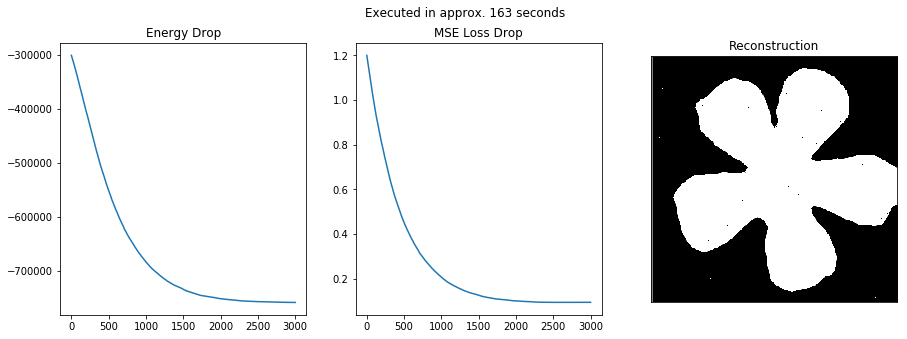

Mean field approximation with lambda =1.0


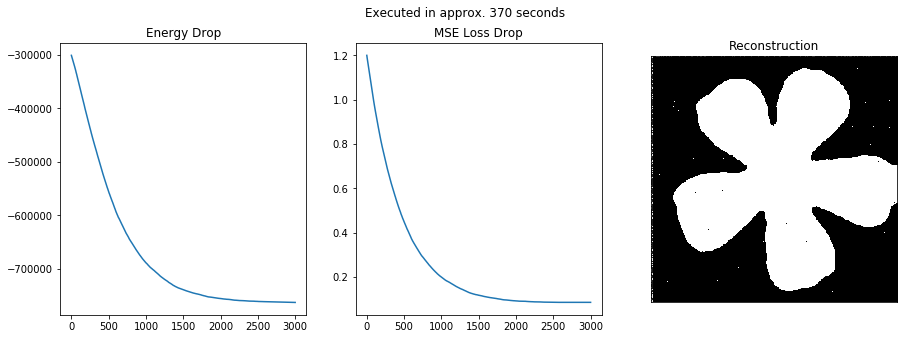

Mean field approximation with lambda =5.0


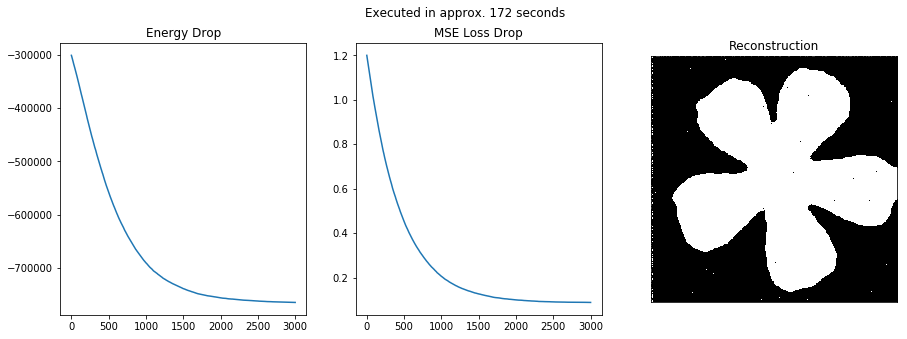

Mean field approximation with lambda =10.0


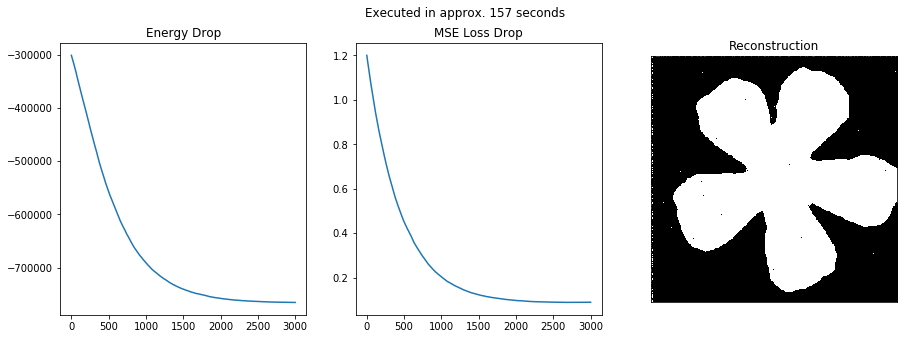

Mean field approximation with lambda =100.0


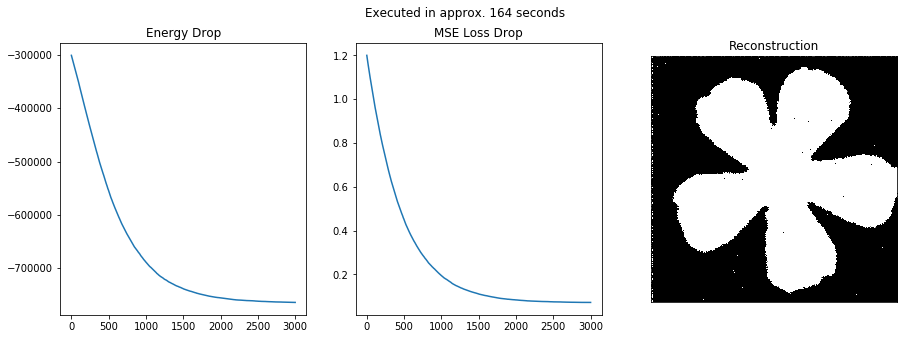

In [122]:
for lambda_ in [0.001, 1.0, 5.0, 10.0, 100.0]:
    print("Mean field approximation with lambda ={0}".format(lambda_))
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5, [lambda_,1.0,3,0.1])

Mean field approximation with lambda = 10000


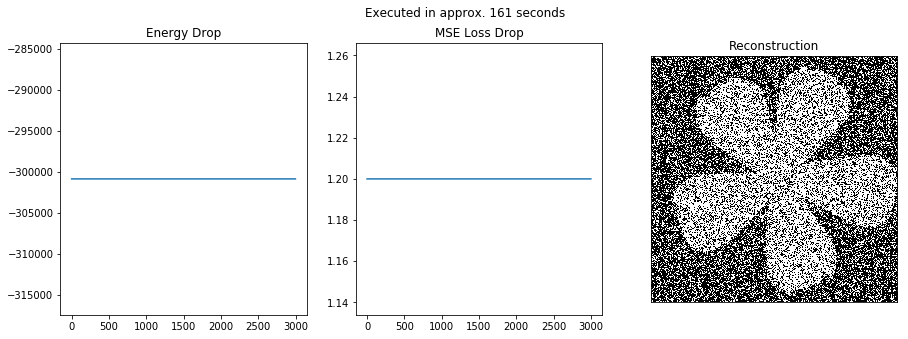

In [127]:
print("Mean field approximation with lambda = 10000")
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5, [10000.0,1.0,3,0.1])

Naturally, for very large values of $\lambda$, we'll get reconstructions that are closer to the noisy image. Or equal to the noisy image, as in the extreme case of $\lambda = 10000$.

### Experiment 2
When varying the width of the window around a given pixel, we find that, as expected, larger window sizes leads to smoother reconstructions. 

Mean field approximation with window width of neighbourhood =1


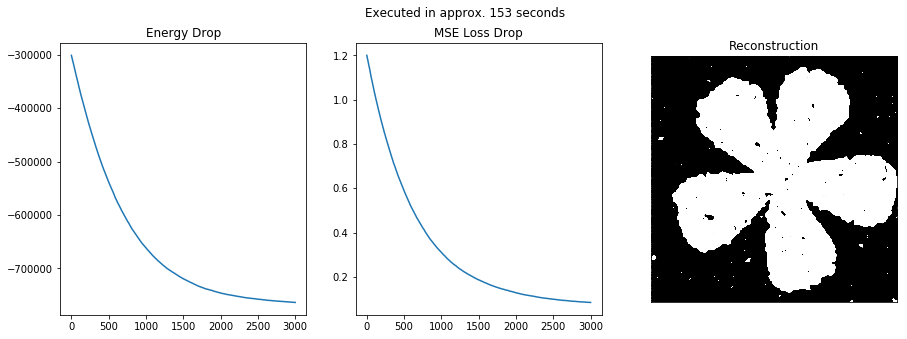

Mean field approximation with window width of neighbourhood =3


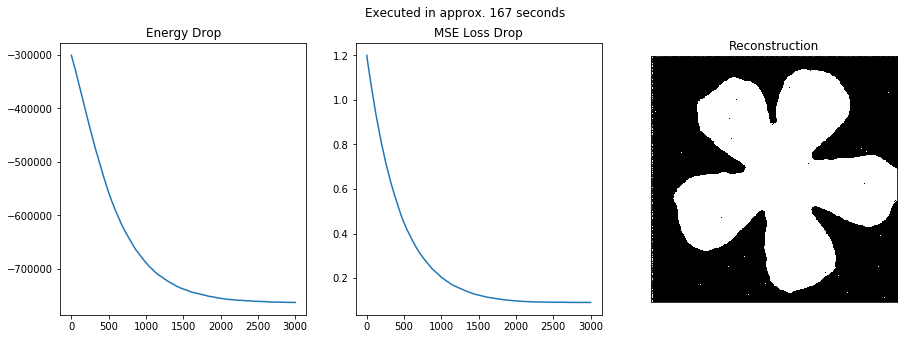

Mean field approximation with window width of neighbourhood =5


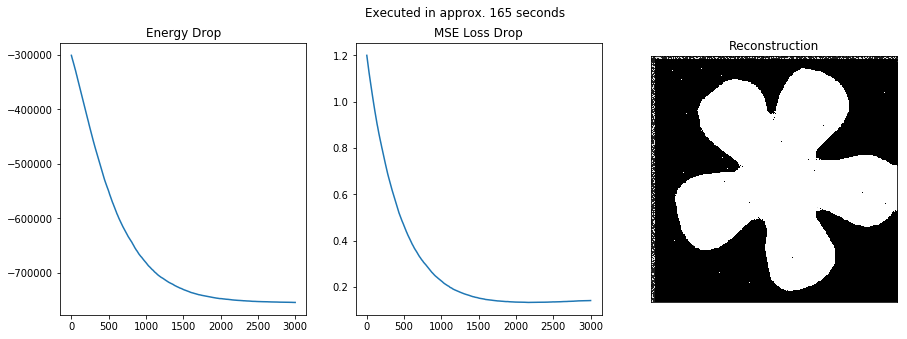

In [124]:
for window_width in [1,3,5]:
    print("Mean field approximation with window width of neighbourhood ={0}".format(window_width))
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5, [1.0,1.0,window_width,0.1])

### Experiment 3
Next, we consider how the magnitude of the $J_{ik}$ parameters influence the outcome of the mean field approximation. Again, we find the algorithm to be quite robust to changes to the magnitude of the $J_{ik}$ parameters.

Mean field approximation with window width of neighbor weights =0.5


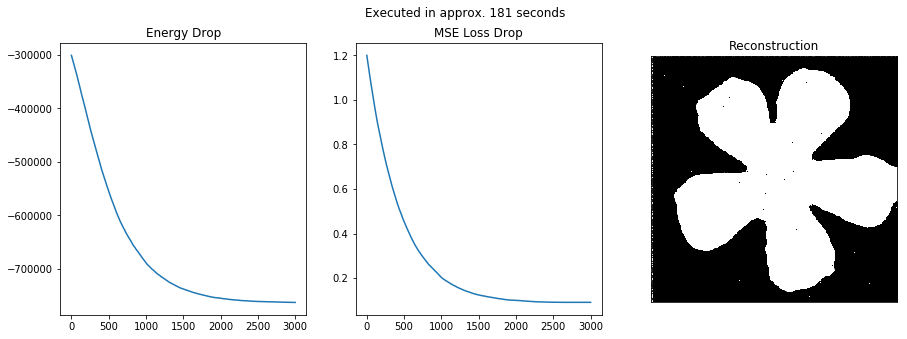

Mean field approximation with window width of neighbor weights =0.01


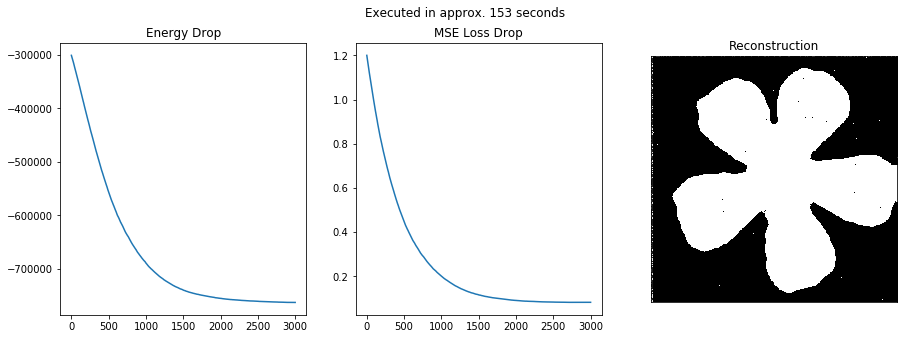

Mean field approximation with window width of neighbor weights =0.0001


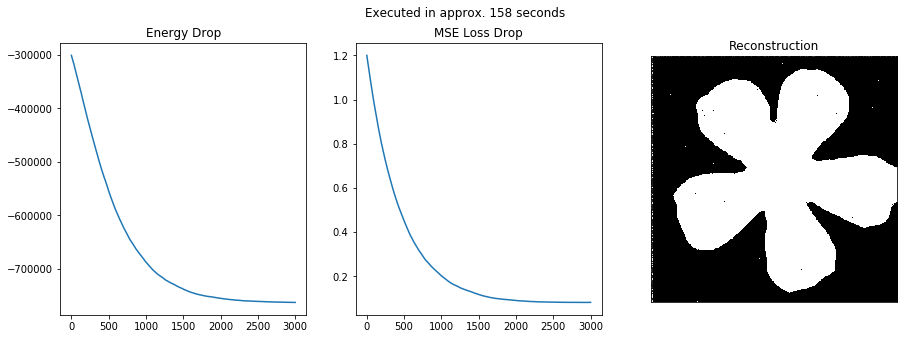

Mean field approximation with window width of neighbor weights =1e-07


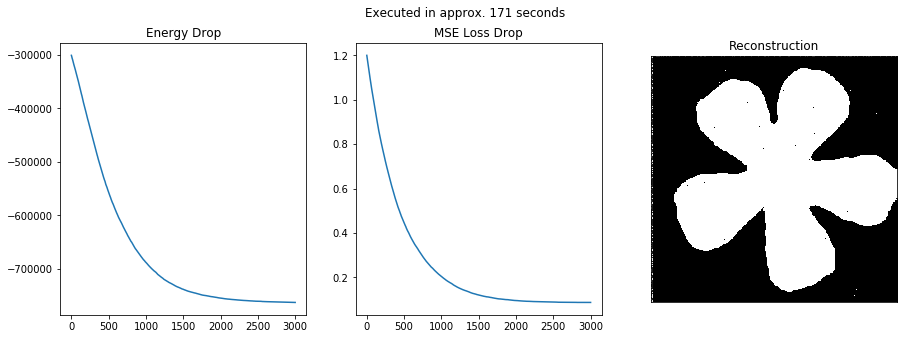

In [125]:
for neighbor_weight in [0.5, 0.01, 0.0001, 0.0000001]:
    print("Mean field approximation with window width of neighbor weights ={0}".format(neighbor_weight))
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5, [1.0,1.0,3,neighbor_weight])

### Experiment 4

Lastly, we consider how different choices of $\beta$ influence the outcome. We would expect that higher values to lead to more extreme outcomes, since it amplifies the input to the tanh function. We find that the algorithm breaks down for extremely small values of $\beta$, presumably because all of the outputs of the $tanh()$ function are going to be fairly similar. Apart from these very small values, the algorithm is quite stable with regards to $\beta$.

Mean field approximation with beta=1e-06


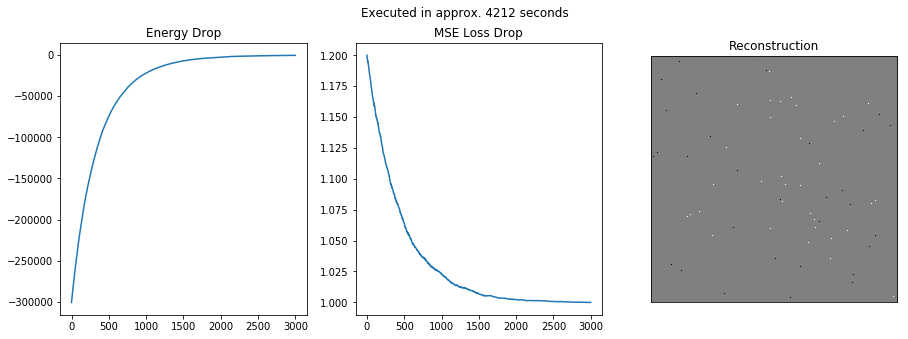

Mean field approximation with beta=0.01


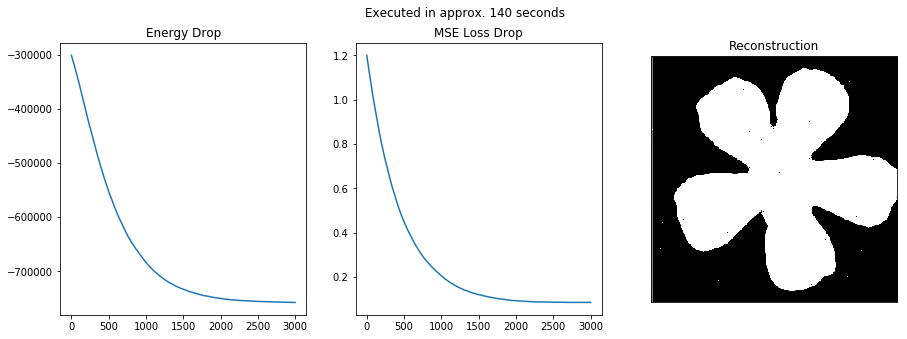

Mean field approximation with beta=1


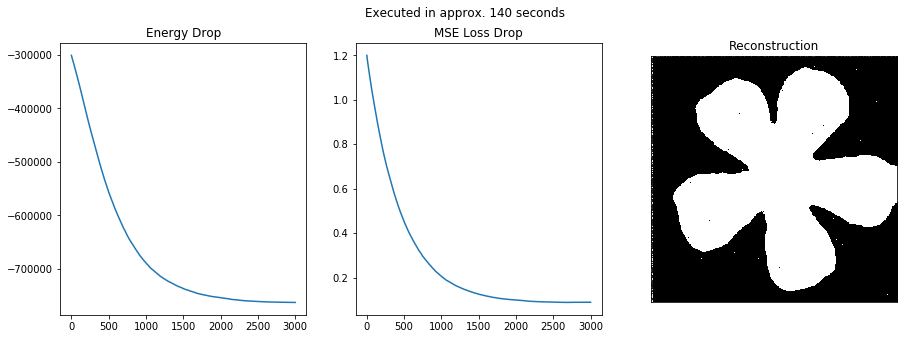

Mean field approximation with beta=50


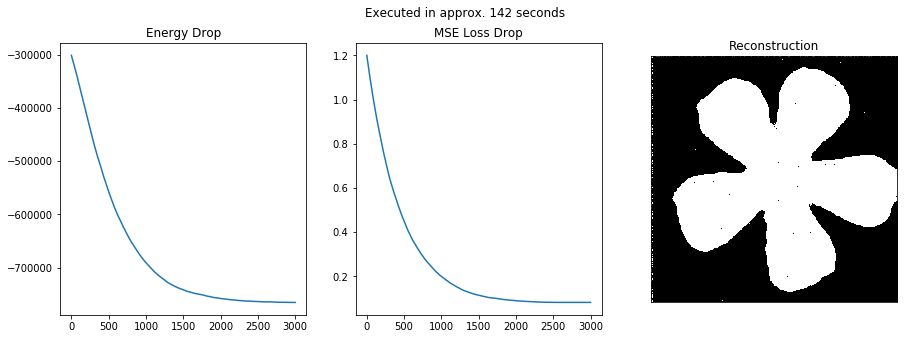

In [123]:
for beta in [0.000001, 0.01, 1, 50]:
    print("Mean field approximation with beta={0}".format(beta))
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5, [1.0,beta,3,0.01])

Overall, this implementation of the mean field approximation seems relatively robust to changes in the parameters.

## Problem 5

Is there something specific to the given image, which makes it more suitable for one or the other method? Feel free to use another image to prove your point?

My implementation of the mean field algorithm benefits from having relatively homogeneous patches in the image. It might do worse on images containing more fine grained textures or more complex structure. To test this I compare the reconstructions of the two algorithms on an image consisting of vertical lines. 

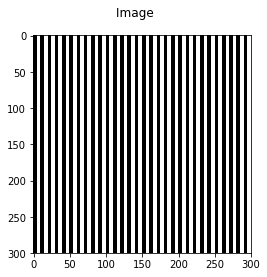

In [110]:
stripes = np.zeros((300,300))
stripe_width = 5
for i in range(0,300,stripe_width):
    value = -1 if i % 2 == 0 else 1
    stripes[:,i:i+stripe_width] = value
plt.imshow(stripes, cmap="gray")
plt.suptitle("Image ")
plt.show()

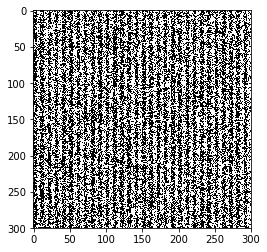

In [102]:
noisy_stripes = add_noise_to_image(stripes)
plt.imshow(noisy_stripes, cmap="gray")

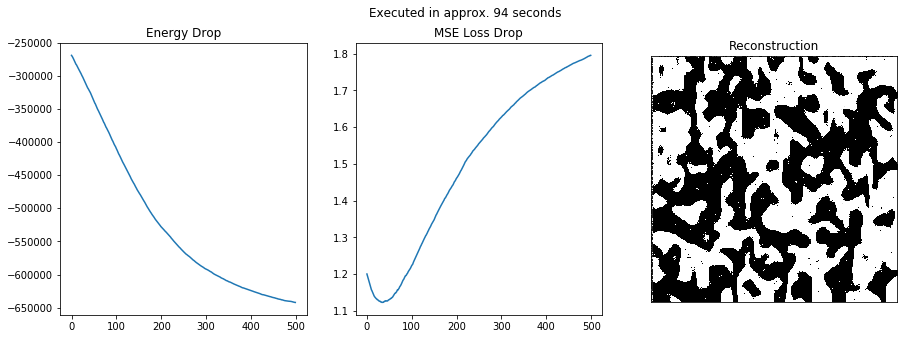

In [107]:
evaluate(meanfield, noisy_stripes, stripes, 5, [1.0,1.0,3,0.01])

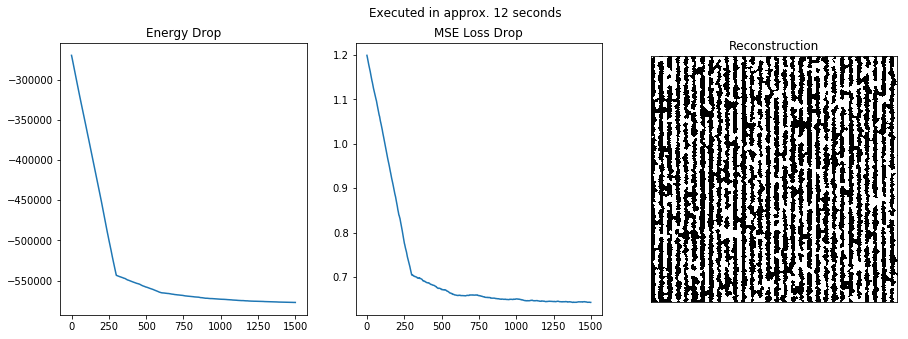

In [105]:
evaluate(metropolis, noisy_stripes, stripes, 5,[])

As we can see, mean field approximation using the same parameters as for the flower image fails to correctly reconstruct the image, while the metropolis algorithm is able to retrieve the original structure. Reducing the window width for the mean field approximation, however, the algorithm is also able to find a reconstruction of similar quality. 

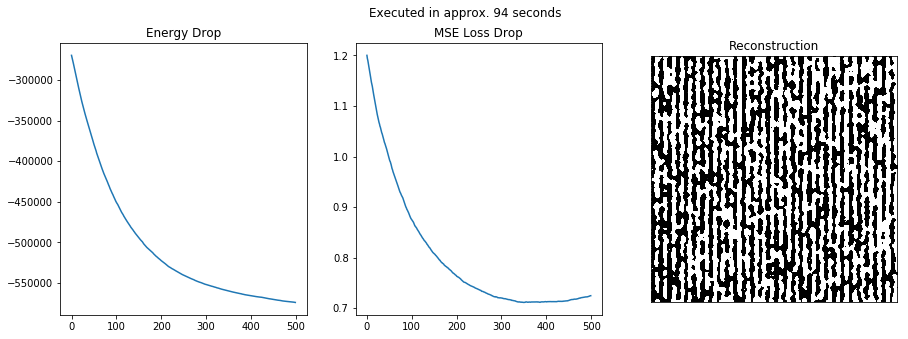

In [108]:
evaluate(meanfield, noisy_stripes, stripes, 5, [1.0,1.0,1,0.01])

# Extension: Smooth k-means

For this part of the task please use the Wine data set (different one than before, see [3]). It contains three classes, see more detailed description online. Implement both, plain-vanilla k-means and smooth k-means [1] and compare them on the Wine data set.

Implementation:

Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.

Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.

Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). Does it indicate 3 clusters?

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in this box. This will help us improve our exercises. Thank you in advance!

I appreciate it that you provided the helper functions like evaluate() and that we didn't have to implement them ourselves.

It wasn't obvious to me how the solutions to exercise sheet 10 related to the problem sheet. It seems like it offers answers to other questions than the ones being asked in the problem sheet. 